
 ### **Task 1: Training a DQN Agent on the Racetrack Environment**
- Implement a **Deep Q-Network (DQN) agent from scratch** using the provided configuration file (`config.py`).
- Documentation on https://highway-env.farama.org/
- The training process should be documented, including:
  - Observations of different learning phases.
  - Performance evaluation of the trained agent.
  - Analysis of achieved rewards and behavior.


## 0 - Imports

In [28]:
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import highway_env
import numpy as np
import time
from tqdm import tqdm
import torch

from configs.config import config_dict

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1 - DQN training  

In [30]:
# Create and configure environment
env = gym.make("highway-fast-v0", render_mode=None)
env.unwrapped.configure(config_dict)  # Use unwrapped environment to configure
env.reset()
# plt.imshow(env.render())

(array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           1.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           1.        ,  0.        ,  0.        ,  0.        ]],

In [31]:

from dqn import DQN

# # Updated DQN hyperparameters
# agent = DQN(
#     action_space=env.action_space,
#     observation_space=env.observation_space,
#     gamma=0.95,                  # discount factor lowered for more near-term focus
#     batch_size=32,               # smaller batch size for more stochastic updates
#     buffer_capacity=50000,       # increased replay buffer capacity for diverse experiences
#     update_target_every=500,     # less frequent target network updates for stability
#     epsilon_start=1.0,           # initial exploration rate remains unchanged
#     decrease_epsilon_factor=15,  # slower decay rate to maintain exploration longer
#     epsilon_min=0.1,             # minimum exploration rate
#     learning_rate=5e-4           # reduced learning rate to help with convergence stability
# )

# Initialize the DQN agent
# agent = DQN(
#     action_space=env.action_space,
#     observation_space=env.observation_space,
#     gamma=0.99,                  # discount factor
#     batch_size=64,               # batch size for training
#     buffer_capacity=10000,       # replay buffer capacity
#     update_target_every=100,     # update target network every N steps
#     epsilon_start=1.0,           # initial exploration rate
#     decrease_epsilon_factor=10,  # controls how quickly epsilon decreases
#     epsilon_min=0.1,             # minimum exploration rate
#     learning_rate=1e-3           # learning rate
# )

# Initialize the DQN agent
agent = DQN(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,                  # discount factor
    batch_size=64,               # batch size for training
    buffer_capacity=10000,       # replay buffer capacity
    update_target_every=100,     # update target network every N steps
    epsilon_start=1.0,           # initial exploration rate
    decrease_epsilon_factor=5,  # controls how quickly epsilon decreases
    epsilon_min=0.1,             # minimum exploration rate
    learning_rate=1e-3           # learning rate
)

# Training parameters
n_episodes = 1000
max_steps_per_episode = 200
save_every = 10000    # save model every N episodes

In [32]:
# For tracking progress
episode_rewards = []
episode_losses = []
epsilon_history = []

start_time = time.time()
def format_time(seconds):
    """Convert seconds to hh:mm:ss format"""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Training loop
# for episode in tqdm(range(n_episodes), desc="Training Episodes"):
for episode in range(n_episodes):
    state, _ = env.reset()
    episode_reward = 0
    episode_loss = 0
    step_count = 0
    
    for step in range(max_steps_per_episode):
        # Get action from agent
        action = agent.get_action(state, env)
        
        # Take action in environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # Update agent
        loss = agent.update(state, action, reward, terminated, next_state)
        
        # Track metrics
        if not np.isinf(loss):
            episode_loss += loss
        episode_reward += reward
        step_count += 1
        
        # Update state
        state = next_state
        
        if done:
            break
    
    # Store metrics
    avg_loss = episode_loss / step_count if step_count > 0 else 0
    episode_rewards.append(episode_reward)
    episode_losses.append(avg_loss)
    epsilon_history.append(agent.epsilon)
    
    # Print progress
    window_size = 100  # window size for rolling averages
    if episode % 10 == 0 and episode!=0:
        # Calculate rolling averages
        rolling_reward = np.mean(episode_rewards[-window_size:])
        rolling_loss = np.mean(episode_losses[-window_size:])
        time_elapsed = time.time() - start_time
        estimated_time_left = (time_elapsed/episode)*(n_episodes-episode) 
        
        # Print progress with rolling averages
        print(f"Ep {episode:3d} | "
            f"Reward: {episode_reward:7.1f} (avg: {rolling_reward:7.1f}) | "
            f"Loss: {avg_loss:7.3f} (avg: {rolling_loss:7.3f}) | "
            f"Epsilon: {agent.epsilon:.3f} | "
            f"Steps: {step_count:3d} | "
            f"Estimated time left: {format_time(estimated_time_left)}", end='\r')
    
    # Save model checkpoint periodically
    if save_every > 0 and (episode + 1) % save_every == 0:
        checkpoint_path = f"models/task_1_ep{episode+1}.pth"
        torch.save({
            'episode': episode + 1,
            'model_state_dict': agent.q_net.state_dict(),
            'optimizer_state_dict': agent.optimizer.state_dict(),
            'loss': avg_loss,
            'reward': episode_reward,
            'epsilon': agent.epsilon
        }, checkpoint_path)
        print(f"\nSaved checkpoint to {checkpoint_path}")


# Final save and new line after training completes
final_model_path = "models/task_1_final.pth"
torch.save(agent.q_net.state_dict(), final_model_path)
print(f"\nTraining complete. Final model saved to {final_model_path}")

Ep 990 | Reward:    43.2 (avg:    37.7) | Loss:  88.198 (avg:  70.496) | Epsilon: 0.100 | Steps:  60 | Estimated time left: 00:00:43
Training complete. Final model saved to models/task_1_final.pth


## 2 - Observation of different learning phases

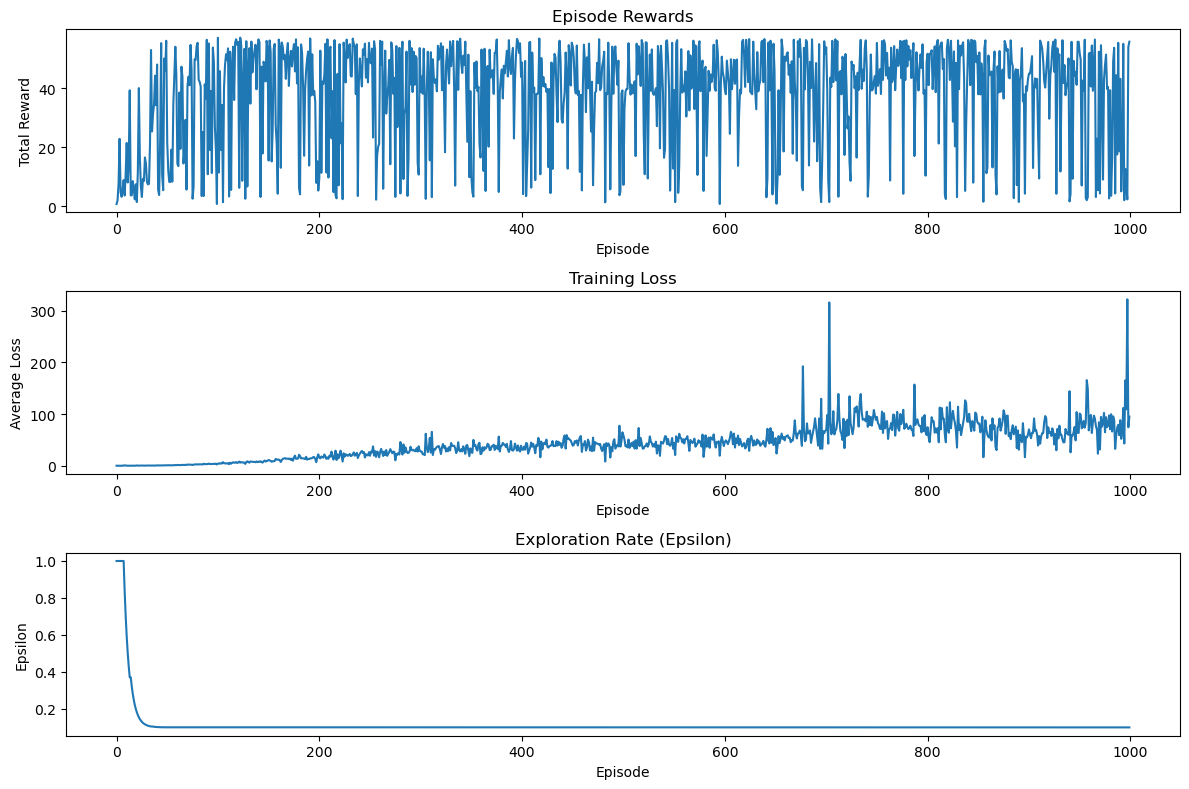

In [33]:
# Plot training results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(3, 1, 2)
plt.plot(episode_losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Average Loss')

plt.subplot(3, 1, 3)
plt.plot(epsilon_history)
plt.title('Exploration Rate (Epsilon)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

## 3 - Performance evaluation of the trained agent

In [34]:
# Performance evaluation of the model

def evaluate_agent(env, agent, n_episodes=10):
    total_rewards = []
    n_successes = 0
    for episode in range(n_episodes):
        print(f"Evaluating episode {episode + 1}/{n_episodes}", end='\r')
        obs, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.get_action(obs, env, epsilon=0.0)  # Use epsilon=0 for evaluation
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        total_rewards.append(total_reward)
        if info["crashed"] == False:
            n_successes += 1

    return np.mean(total_rewards), np.std(total_rewards), n_successes / n_episodes

# Evaluate the agent
mean_reward, std_reward, success_rate = evaluate_agent(env, agent)
print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Success Rate: {success_rate:.2%}")

Mean Reward: 32.39 ± 18.69
Success Rate: 70.00%


## 4 - Analysis of achieved rewards and behavior

In [ ]:
# Create and configure environment
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config_dict)  # Use unwrapped environment to configure
env.reset()

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action = agent.get_action(obs, env, epsilon=0.0)  # Use epsilon=0 for evaluation
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()